## **Notebook Summary**

### **Purpose**
This notebook evaluates and visualizes the performance of a clinical trial-patient matching system ("trial_matches.json"), comparing system-assigned trial suitability verdicts against curated gold-standard labels.

---

### **Key Steps and Logic**

#### **1. Data Loading**
- Loads:
  - **Gold/reference** patient-trial pairs and scores from `test.tsv`.
  - **Patient queries** and **trial corpus** from `queries.jsonl` and `corpus.jsonl`.
  - **Trial matches** (detailed matching outputs) from `matched/trial_matches.json` (contains verdicts, reasoning about inclusion/exclusion).

#### **2. Flatten & Normalize Trial Matches**
- Iterates through `trial_matches.json` to **flatten nested structures** into a DataFrame:
  - Columns include: `query-id`, `corpus-id`, model trial verdict (`match_verdict`), reasoning, inclusion/exclusion flags, and detailed eligibility explanations.

#### **3. Merge Gold with System Predictions**
- Merges gold-standard pairs (`df_tsv`) with matched verdicts (`df_trial_matches`) by query and trial IDs.
- Ensures **all gold pairs are present**, filling unmatched ones with NaN for later filtering/checks.

#### **4. Label Harmonization**
- Maps system verdicts (“STRONG MATCH”, “POSSIBLE MATCH”, “WEAK MATCH”, “UNSUITABLE”) into numeric label space {0, 1, 2} for comparison:
  - 2: Highly likely ("STRONG MATCH" or "POSSIBLE MATCH")
  - 1: Would consider ("WEAK MATCH")
  - 0: Would not refer ("UNSUITABLE")
- Aligns ground-truth labels from gold file into the same space.

#### **5. Evaluation**
- **Omissions:** Reports count/samples of pairs where there is no system verdict (excluded from scoring).
- **Metrics:**
  - Computes **confusion matrix** (tabular and heatmap) to visualize agreement.
  - Calculates **macro-averaged F1 score** and displays a full classification report (precision/recall per label).
- **Visualization:** Plots the confusion matrix with Seaborn for a clear model performance summary.

#### **6. Inspection & Quality Control**
- Provides options to display merged/evaluated DataFrame (with explanations/reasoning), as well as any omitted/missing rows.

#### **7. Display/Output**
- Configures pandas for wide displays, allowing direct inspection of large slices of merged data and reasoning fields.

---

### **Outputs**
- **Metrics for Model QA:** Confusion matrix, macro F1, precision/recall for each decision level.
- **Visualization:** Color-coded confusion matrix heatmap for rapid error pattern assessment.
- **Inspection:** Full merged DataFrame can be displayed, supporting qualitative analysis via system reasoning and verdicts.

---

### **Intended Use**
- **Model validation and debugging:** Evaluate system-patient-to-trial assignment quality.
- **Insight into errors:** Directly reveals misclassifications and their reasoning by exploring DataFrame rows.
- **Transparent reporting:** Well-suited for sharing system strengths and weaknesses with stakeholders or during clinical IR system development.

---

### **Technical/Architectural Notes**
- **Robust merging:** Ensures all reference pairs are considered, not just those found by the matcher.
- **Extendable:** Can be easily fit for other datasets or more granular scoring/justification analysis.
- **User-friendly:** Designed for rapid exploratory analysis, including straightforward displays for both summary and raw data.

In [1]:
import os
import json
import pandas as pd
import numpy as np

In [2]:
# Set pandas display options 
pd.set_option('display.max_rows', 3)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 200)

In [3]:
import os
import pandas as pd
import json

# Set up paths
DATA_DIR = "../data/sigir2016/processed_cut"
MATCHED_DIR = "../data/sigir2016/matched"

TSV_FILE = os.path.join(DATA_DIR, "test.tsv")
QUERIES_FILE = os.path.join(DATA_DIR, "queries.jsonl")
CORPUS_FILE = os.path.join(DATA_DIR, "corpus.jsonl")
TRIAL_MATCHES_FILE = os.path.join(MATCHED_DIR, "trial_matches.json")

# Load main input data
df_tsv = pd.read_csv(TSV_FILE, sep='\t')
df_queries = pd.read_json(QUERIES_FILE, lines=True)
df_corpus = pd.read_json(CORPUS_FILE, lines=True)

In [4]:
print(f" df_tsv {len(df_tsv)} df_queries {len(df_queries)} df_corpus {len(df_corpus)}")

 df_tsv 3870 df_queries 59 df_corpus 3626


In [5]:
# Glimpse at dataframes:
display(df_tsv.head())
display(df_queries.head())
display(df_corpus.head())
# display(trial_matches_long.head())

# ---- Now you can proceed with analysis & evaluation below!

,query-id,corpus-id,score
0,sigir-20141,NCT00000408,0
...,...,...,...
4,sigir-20141,NCT00004727,0


,_id,text
0,sigir-20141,A 58-year-old African-American woman presents to the ER with episodic pressing/burning anterior chest pain that began two days earlier for the first time in her life. The pain started while she wa...
...,...,...
4,sigir-20145,A 56-year-old female on 20th day post-left mastectomy presents to the emergency department complaining of shortness of breath and malaise. The patient says that she has remained in bed for the las...


,_id,title,metadata
0,NCT00000369,Maintenance Therapies in Bipolar Disorders,"{'phase': 'Phase 3', 'drugs': '['Individual psychotherapy', 'Lithium carbonate']', 'drugs_list': ['Individual psychotherapy', 'Lithium carbonate'], 'diseases_list': ['Bipolar Disorder'], 'enrollme..."
...,...,...,...
4,NCT00000432,Lyme Disease Prevention Program,"{'phase': 'Phase 3', 'drugs': '['Education about disease prevention']', 'drugs_list': ['Education about disease prevention'], 'diseases_list': ['Lyme Disease', 'Tick-Borne Diseases'], 'enrollment'..."


In [6]:
TRIAL_MATCHES_FILE = os.path.join(MATCHED_DIR, "trial_matches.json")

# Load the JSON as a list of dicts
with open(TRIAL_MATCHES_FILE, "r") as f:
    trial_matches = json.load(f)

# Flattening loop
records = []
for patient_dict in trial_matches:
    patient_id = patient_dict['patient_id']
    for eval_ in patient_dict['trial_evaluations']:
        trial_id = eval_['trial_id']
        trial_title = eval_.get('trial_title')
        scoring = eval_.get('scoring_result', {})
        inclusion = eval_.get('inclusion_result', {})
        exclusion = eval_.get('exclusion_result', {})
        records.append({
            'query-id': patient_id,
            'corpus-id': trial_id,
            'trial_title': trial_title,
            # From scoring_result
            'score': scoring.get('score'),
            'match_verdict': scoring.get('verdict'),
            'match_reasoning': scoring.get('reasoning'),
            # From exclusion_result
            'exclusion_verdict': exclusion.get('verdict'),
            'exclusion_reason': exclusion.get('reason'),
            # From inclusion_result
            'inclusion_verdict': inclusion.get('verdict'),
            'inclusion_missing_info': inclusion.get('missing_information'),
            'inclusion_unmet_criteria': inclusion.get('unmet_criteria'),
            'inclusion_reasoning': inclusion.get('reasoning'),
        })

# Create DataFrame
df_trial_matches = pd.DataFrame(records)

# Preview
# pd.set_option('display.max_colwidth', 200)
# display(df_trial_matches.head())

In [7]:
df_trial_matches['score'] = df_trial_matches['score'].fillna(0)
df_trial_matches['match_verdict'] = df_trial_matches['match_verdict'].fillna("WOULD NOT REFER")

In [8]:
len(df_trial_matches)

7552

In [9]:
# df_tsv: gold/reference pairs
# df_trial_matches: detailed match+reasoning info from trial_matches.json

# Merge, keeping all gold standard pairs and including trial_matches info when available:
merged_df = df_tsv.merge(df_trial_matches, on=['query-id', 'corpus-id'], how='left')

In [10]:
# 1. Merge queries info (like 'text') into merged_df
merged_df = merged_df.merge(
    df_queries.rename(columns={'_id': 'query-id'}),
    on='query-id',
    how='left'
)

# 2. Merge corpus info (like 'title', 'metadata') into merged_df
merged_df = merged_df.merge(
    df_corpus.rename(columns={'_id': 'corpus-id'}),
    on='corpus-id',
    how='left'
)
# Drop the 'title' column
merged_df = merged_df.drop(columns=['title'])

Rows with missing match_verdict (excluded from evaluation): 1746

Confusion matrix (table):



,0) WOULD NOT REFER,1) WOULD CONSIDER REFERRAL,2) HIGHLY LIKELY TO REFER
0) WOULD NOT REFER,782,398,51
1) WOULD CONSIDER REFERRAL,139,302,92
2) HIGHLY LIKELY TO REFER,65,151,144



Macro F1 score: 0.5290

Detailed classification report:

                            precision    recall  f1-score   support

        0) WOULD NOT REFER       0.79      0.64      0.71      1231
1) WOULD CONSIDER REFERRAL       0.35      0.57      0.44       533
 2) HIGHLY LIKELY TO REFER       0.50      0.40      0.45       360

                  accuracy                           0.58      2124
                 macro avg       0.55      0.53      0.53      2124
              weighted avg       0.63      0.58      0.59      2124



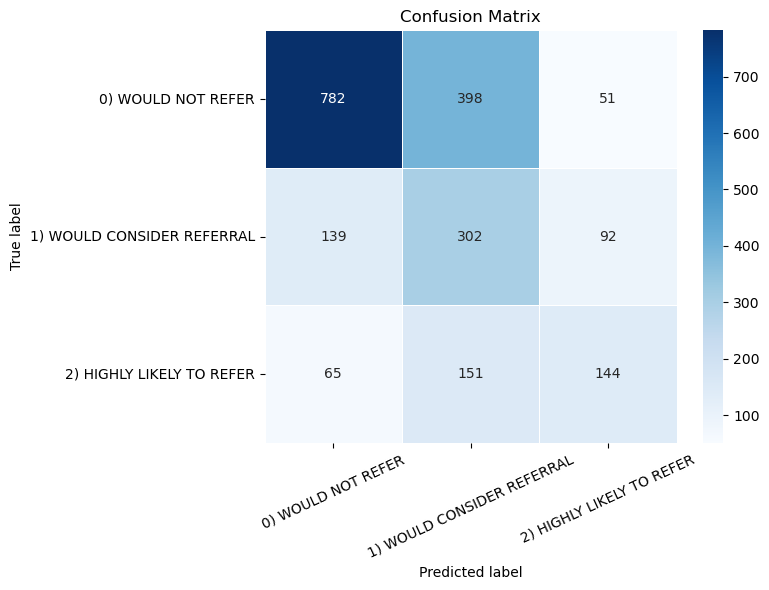

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score, classification_report
import pandas as pd

verdict_map = {
    "HIGHLY LIKELY TO REFER": 2,
    "WOULD CONSIDER REFERRAL": 1,
    "WOULD NOT REFER": 0,
    "None": 0,
}

merged_df['predicted_label'] = merged_df['match_verdict'].map(verdict_map)#.fillna(0).astype(int)
merged_df['true_label'] = merged_df['score_x']

labels = [0, 1, 2]
label_names = [
    "0) WOULD NOT REFER",
    "1) WOULD CONSIDER REFERRAL",
    "2) HIGHLY LIKELY TO REFER"
]

n_missing = merged_df['match_verdict'].isna().sum()
print(f"Rows with missing match_verdict (excluded from evaluation): {n_missing}")

eval_df = merged_df[~merged_df['predicted_label'].isna() & ~merged_df['true_label'].isna()]
y_true = eval_df['true_label'].astype(int)
y_pred = eval_df['predicted_label'].astype(int)

cm = confusion_matrix(y_true, y_pred, labels=labels)
f1 = f1_score(y_true, y_pred, labels=labels, average='macro')

print("\nConfusion matrix (table):\n")
cm_df = pd.DataFrame(cm, index=label_names, columns=label_names)
display(cm_df)

print("\nMacro F1 score: {:.4f}".format(f1))
print("\nDetailed classification report:\n")
print(classification_report(y_true, y_pred, labels=labels, target_names=label_names))

# Blue Confusion Matrix Plot
plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=True, linewidths=.5, square=False)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.yticks(rotation=0)
plt.xticks(rotation=25)
plt.tight_layout()
plt.show()

# # Show omitted rows if any
# if n_missing > 0:
#     print("\nSample of omitted rows (no match_verdict):")
#     display(merged_df[merged_df['match_verdict'].isna()].head())

In [12]:
# Cell 1: True label 2, prediction available
df_true2_pred = merged_df[(merged_df["score_x"] == 2) & (merged_df["predicted_label"] == 0)]
display(df_true2_pred)
print(f"Rows: {len(df_true2_pred)}")

,query-id,corpus-id,score_x,trial_title,score_y,match_verdict,match_reasoning,exclusion_verdict,exclusion_reason,inclusion_verdict,inclusion_missing_info,inclusion_unmet_criteria,inclusion_reasoning,text,metadata,predicted_label,true_label
299,sigir-201413,NCT00163709,2,BNP Testing in Patients With SOB on Presentation to ED,0,WOULD NOT REFER,None,PASS,"Patient does not meet any exclusion criteria. The patient's shortness of breath is not specified as being due to a traumatic cause, and there is no indication of severe renal disease, cardiogenic ...",FAIL,None,The patient's age is below the specified threshold of over 40 years old.,"The patient is 30 years old, which clearly does not meet the inclusion criterion of being over 40 years old. Although the patient presents with shortness of breath and other relevant symptoms, the...",A 30-year-old generally healthy woman presents with shortness of breath that had started 2 hours before admission. She has had no health problems in the past besides 2 natural abortions. She had g...,"{'phase': 'Phase 1', 'drugs': '['BNP test']', 'drugs_list': ['BNP test'], 'diseases_list': ['Heart Failure, Congestive'], 'enrollment': '600', 'inclusion_criteria': 'We plan to include all patient...",0.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3630,sigir-20156,NCT01247077,2,Neuropsychologic and Immunological Evaluation in Treatment of Thyroid Diseases. Is Selenium Efficient?,0,WOULD NOT REFER,None,EXCLUDE,"The patient meets the exclusion criterion of ""No severe ophthalmopathy, or other severe disease"" due to the presence of ""Mild exophthalmia"" in the physical examination findings. Although it is des...",None,None,None,None,"A 46-year-old woman presents with a 9 month history of weight loss (20 lb), sweating, insomnia and diarrhea. She reports to have been eating more than normal and that her heart sometimes races fo...","{'phase': 'Phase 2', 'drugs': '['selenium', 'placebo']', 'drugs_list': ['selenium', 'placebo'], 'diseases_list': ['QoL Before and After 9 Month of Medical Treatment of Graves´Thyrotoxicosis', 'Pot...",0.0,2


Rows: 65


In [13]:
# Cell 1: True label 2, prediction available
df_true2_pred = merged_df[(merged_df["score_x"] == 2) & (merged_df["predicted_label"] == 2)]
display(df_true2_pred)
print(f"Rows: {len(df_true2_pred)}")

,query-id,corpus-id,score_x,trial_title,score_y,match_verdict,match_reasoning,exclusion_verdict,exclusion_reason,inclusion_verdict,inclusion_missing_info,inclusion_unmet_criteria,inclusion_reasoning,text,metadata,predicted_label,true_label
6,sigir-20141,NCT00005485,2,Environmental and Genetic Factors That Influence Cardiovascular Disease in African Americans,8,HIGHLY LIKELY TO REFER,"The patient's profile aligns well with the clinical trial's focus on cardiovascular diseases in African Americans. The key eligibility criterion of being African American is met, as stated in the ...",PASS,No exclusion criteria specified,INCLUDE,None,None,"The patient's demographics section clearly states that their ethnicity is African-American, which directly aligns with the trial's inclusion criterion of being African American. Since this is the ...",A 58-year-old African-American woman presents to the ER with episodic pressing/burning anterior chest pain that began two days earlier for the first time in her life. The pain started while she wa...,"{'phase': 'N/A', 'drugs': '[]', 'drugs_list': [], 'diseases_list': ['Cardiovascular Diseases', 'Heart Diseases', 'Atherosclerosis', 'Coronary Disease', 'Hypertension', 'Cerebrovascular Disorders']...",2.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3749,sigir-20157,NCT01682785,2,Incidence of Metabolic Syndrome and Thyroid Dysfunction in Patients With Major Depressive Disorder,8,HIGHLY LIKELY TO REFER,"The patient's symptoms, such as increased sleep and appetite, difficulty concentrating, loss of enjoyment in social activities, and feelings of guilt, align closely with the characteristics of maj...",PASS,"Patient does not meet any exclusion criteria. The exclusion criterion states that a subject who cannot give information should be excluded. However, there is no indication in the patient summary t...",INCLUDE,None,None,"Although the patient's diagnosis is not explicitly stated as major depressive disorder, the primary symptoms described (increased sleep and appetite, difficulty concentrating, loss of enjoyment in...",A 20 yo female college student with no significant past medical history presents with a chief complaint of fatigue. She reports increased sleep and appetite over the past few months as well as dif...,"{'phase': 'N/A', 'drugs': '[]', 'drugs_list': [], 'diseases_list': ['Major Depressive Disorder', 'Metabolic Syndrome', 'Thyroid Dysfunction'], 'enrollment': '140', 'inclusion_criteria': '- patient...",2.0,2


Rows: 144


In [14]:
# Cell 2: True label 1, prediction available
df_true1_pred = merged_df[(merged_df["score_x"] == 1) & (merged_df["predicted_label"] == 1)]
display(df_true1_pred)
print(f"Rows: {len(df_true1_pred)}")

,query-id,corpus-id,score_x,trial_title,score_y,match_verdict,match_reasoning,exclusion_verdict,exclusion_reason,inclusion_verdict,inclusion_missing_info,inclusion_unmet_criteria,inclusion_reasoning,text,metadata,predicted_label,true_label
22,sigir-20141,NCT00225355,1,Rosiglitazone Versus Placebo in Chronic Stable Angina,5,WOULD CONSIDER REFERRAL,"The patient's chief complaint of episodic pressing/burning anterior chest pain could suggest angina, which aligns with the trial's focus on chronic stable angina. However, the duration of only two...",PASS,"Patient does not meet any exclusion criteria. The patient's medical history does not mention diabetes mellitus, liver failure, renal failure, cardiac failure, or physical disability that would pre...",UNDETERMINED,- Results of a previous positive exercise tolerance test\n- Disease suitability for coronary intervention (Coronary artery bypass grafting or angioplasty)\n- Body mass index (BMI) value or confirm...,None,The patient's summary lacks crucial details necessary to determine eligibility for the clinical trial. While the patient's chief complaint of episodic pressing/burning anterior chest pain could su...,A 58-year-old African-American woman presents to the ER with episodic pressing/burning anterior chest pain that began two days earlier for the first time in her life. The pain started while she wa...,"{'phase': 'Phase 4', 'drugs': '['Rosiglitazone']', 'drugs_list': ['Rosiglitazone'], 'diseases_list': ['Angina Pectoris', 'Metabolic Syndrome X'], 'enrollment': '80', 'inclusion_criteria': '- Chron...",1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3816,sigir-20158,NCT02562040,1,Pediatric Adenotonsillectomy for Snoring,5,WOULD CONSIDER REFERRAL,"The patient's symptoms, such as nighttime snoring, pauses in breathing, restlessness, and nighttime awakenings, align with the focus of the clinical trial on sleep-disordered breathing. However, c...",PASS,Patient does not meet any exclusion criteria. The provided patient information does not contain any details that would clearly indicate the patient meets any of the specified exclusion criteria. T...,UNDETERMINED,- Obstructive apnea index (OAI) and apnea-hypopnea index (AHI) values from nocturnal polysomnography\n- Specific frequency of parental-reported habitual snoring\n- Tonsillar hypertrophy grade\n- O...,None,"The patient presents with symptoms suggestive of sleep-disordered breathing, such as nighttime snoring, pauses in breathing, restlessness, and nighttime awakenings, which aligns with the concerns ...","A 10 yo boy with nighttime snoring, pauses in breathing, and restlessness with nighttime awakenings. No history of headache or night terrors. The boy's teacher recently contacted his parents becau...","{'phase': 'Phase 3', 'drugs': '['Early Adenotonsillectomy (eAT)', 'Watchful Waiting with Supportive Care (WWSC)']', 'drugs_list': ['Early Adenotonsillectomy (eAT)', 'Watchful Waiting with Supporti...",1.0,1


Rows: 302


In [15]:
# Cell 3: True label 0, prediction available
df_true0_pred = merged_df[(merged_df["score_x"] == 0) & (merged_df["predicted_label"] == 0)]
display(df_true0_pred)
print(f"Rows: {len(df_true0_pred)}")

,query-id,corpus-id,score_x,trial_title,score_y,match_verdict,match_reasoning,exclusion_verdict,exclusion_reason,inclusion_verdict,inclusion_missing_info,inclusion_unmet_criteria,inclusion_reasoning,text,metadata,predicted_label,true_label
17,sigir-20141,NCT00166231,0,Understanding Pediatric Chest Pain and Other Symptoms,0,WOULD NOT REFER,None,PASS,"Patient does not meet any exclusion criteria. The only exclusion criterion mentioned is for non-English speaking patients, but there is no information in the patient summary to suggest that the pa...",FAIL,None,"- Age: The patient is 58 years old, which is outside the 8-18 years of age range specified in the trial inclusion criteria.","The primary reason for the verdict is the clear mismatch between the patient's age and the age range specified in the trial's inclusion criteria. Despite the patient experiencing chest pain, which...",A 58-year-old African-American woman presents to the ER with episodic pressing/burning anterior chest pain that began two days earlier for the first time in her life. The pain started while she wa...,"{'phase': 'N/A', 'drugs': '[]', 'drugs_list': [], 'diseases_list': ['Chest Pain'], 'enrollment': '156', 'inclusion_criteria': '- 8-18 years of age - Pediatric patients with referrals for innocent ...",0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3865,sigir-20159,NCT02459171,0,Household Transmission of Zoonotic Influenza Viruses in a Cohort of Egyptian Poultry Growers,0,WOULD NOT REFER,None,PASS,"Patient does not meet any exclusion criteria. There is no indication of a known immunosuppressive condition, immune deficiency disease, or ongoing receipt of immunosuppressive therapy. The patient...",FAIL,None,"- The criterion that requires individuals to have poultry in the household is not met, as the patient was exposed to domestic pigs, not poultry.","The trial specifically includes poultry-exposed individuals with poultry in the household. The patient's exposure history mentions a stay with relatives on a farm that raises domestic pigs, which ...","A 10 year old child is brought to the emergency room complaining of myalgia, cough, and shortness of breath. Two weeks ago the patient was seen by his pediatrician for low-grade fever, abdominal ...","{'phase': 'N/A', 'drugs': '['Questionnaire', 'Blood sample', 'Nasal wash', 'Throat swab']', 'drugs_list': ['Questionnaire', 'Blood sample', 'Nasal wash', 'Throat swab'], 'diseases_list': ['Influen...",0.0,0


Rows: 782


In [16]:
import numpy as np
from sklearn.metrics import f1_score, classification_report, confusion_matrix

# Only use rows with non-missing score_y and score_x
yx = merged_df.loc[(~merged_df['score_y'].isna()) & (~merged_df['score_x'].isna()), ['score_y', 'score_x']]
score_y = yx['score_y'].values.astype(int)  # model output
score_x = yx['score_x'].values.astype(int)  # true labels

results = []
for cut1 in range(1, 100):
    for cut2 in range(cut1 + 1, 101):
        preds = np.digitize(score_y, bins=[cut1, cut2])  # (0, 1, 2)
        macro_f1 = f1_score(score_x, preds, labels=[0, 1, 2], average="macro")
        f1_1 = f1_score(score_x, preds, labels=[1], average=None)[0]
        f1_2 = f1_score(score_x, preds, labels=[2], average=None)[0]
        results.append({
            "cut1": cut1,
            "cut2": cut2,
            "macro_f1": macro_f1,
            "f1_1": f1_1,
            "f1_2": f1_2
        })

results_df = pd.DataFrame(results)

# Find maxima
best_macro = results_df.loc[results_df['macro_f1'].idxmax()]
best_1 = results_df.loc[results_df['f1_1'].idxmax()]
best_2 = results_df.loc[results_df['f1_2'].idxmax()]



Best cutpoints for macro F1: cut1=5, cut2=7, F1=0.5379
                            precision    recall  f1-score   support

        0) Would not refer       0.79      0.67      0.73      1231
1) Would consider referral       0.38      0.51      0.43       533
 2) Highly likely to refer       0.45      0.46      0.45       360

                  accuracy                           0.59      2124
                 macro avg       0.54      0.55      0.54      2124
              weighted avg       0.63      0.59      0.61      2124

Confusion Matrix:


,0) Would not refer,1) Would consider referral,2) Highly likely to refer
0) Would not refer,824,325,82
1) Would consider referral,146,272,115
2) Highly likely to refer,70,126,164


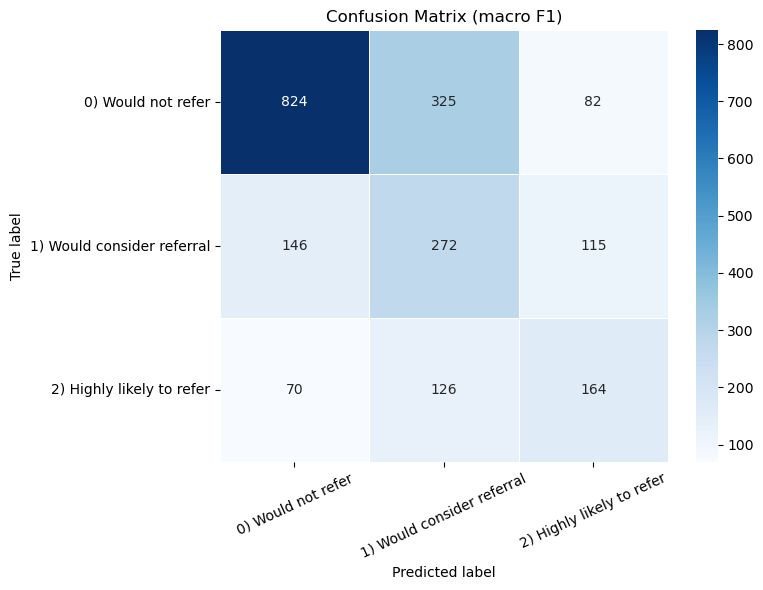


Best cutpoints for score 1 (Would consider): cut1=5, cut2=10, F1=0.4787
                            precision    recall  f1-score   support

        0) Would not refer       0.79      0.67      0.73      1231
1) Would consider referral       0.36      0.73      0.48       533
 2) Highly likely to refer       0.00      0.00      0.00       360

                  accuracy                           0.57      2124
                 macro avg       0.38      0.47      0.40      2124
              weighted avg       0.55      0.57      0.54      2124

Confusion Matrix:


/home/mikenet/.conda/envs/spark_env_jlab/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mikenet/.conda/envs/spark_env_jlab/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mikenet/.conda/envs/spark_env_jlab/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

,0) Would not refer,1) Would consider referral,2) Highly likely to refer
0) Would not refer,824,407,0
1) Would consider referral,146,387,0
2) Highly likely to refer,70,290,0


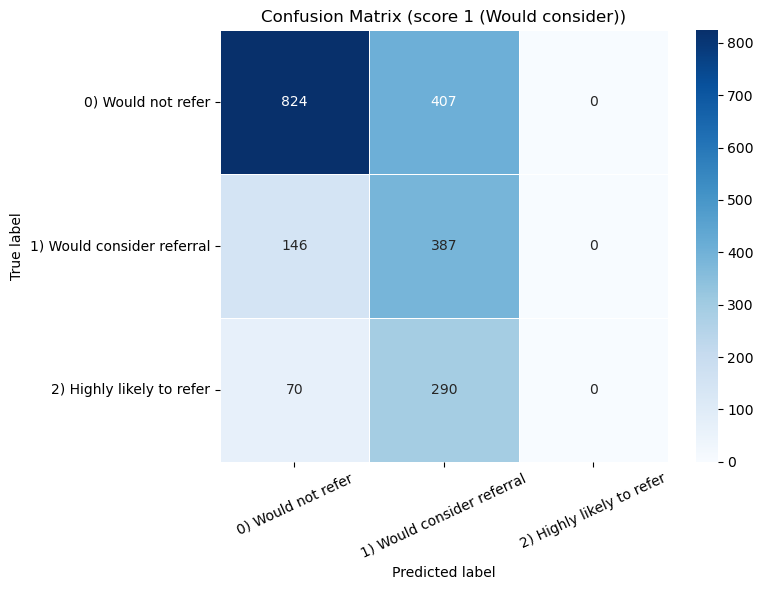


Best cutpoints for score 2 (Highly likely): cut1=1, cut2=7, F1=0.4549
                            precision    recall  f1-score   support

        0) Would not refer       0.79      0.55      0.65      1231
1) Would consider referral       0.33      0.56      0.41       533
 2) Highly likely to refer       0.45      0.46      0.45       360

                  accuracy                           0.53      2124
                 macro avg       0.52      0.52      0.50      2124
              weighted avg       0.62      0.53      0.56      2124

Confusion Matrix:


,0) Would not refer,1) Would consider referral,2) Highly likely to refer
0) Would not refer,675,474,82
1) Would consider referral,121,297,115
2) Highly likely to refer,57,139,164


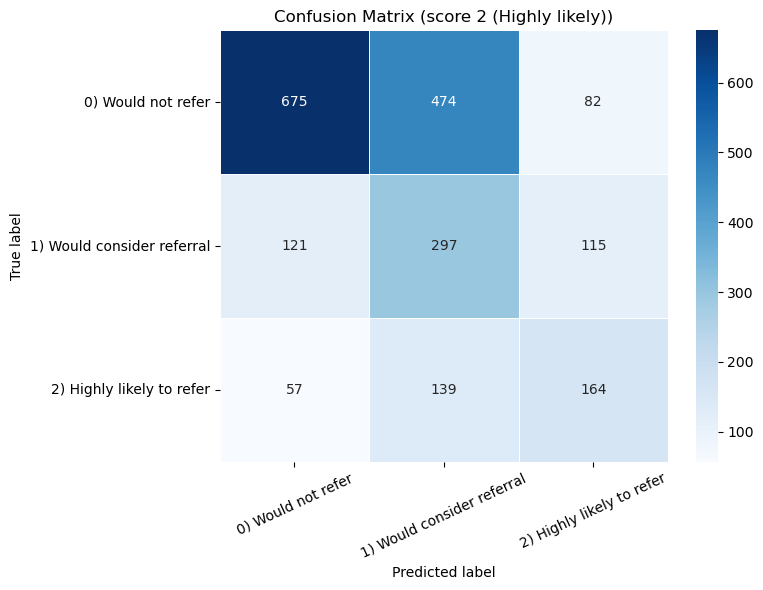

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

cut_labels = [
    "0) Would not refer",
    "1) Would consider referral",
    "2) Highly likely to refer"
]

def display_results_with_plot(cut1, cut2, label, f1val):
    preds = np.digitize(score_y, bins=[cut1, cut2])
    print(f"\nBest cutpoints for {label}: cut1={cut1}, cut2={cut2}, F1={f1val:.4f}")
    print(classification_report(
        score_x, preds, labels=[0, 1, 2],
        target_names=cut_labels
    ))
    cm = confusion_matrix(score_x, preds, labels=[0, 1, 2])
    cm_df = pd.DataFrame(cm, index=cut_labels, columns=cut_labels)
    print("Confusion Matrix:")
    display(cm_df)

    # Blue Confusion Matrix Plot
    plt.figure(figsize=(8,6))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=True, linewidths=.5, square=False)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title(f'Confusion Matrix ({label})')
    plt.yticks(rotation=0)
    plt.xticks(rotation=25)
    plt.tight_layout()
    plt.show()

# Show results and blue CM for each optimal cutpoint set
display_results_with_plot(int(best_macro.cut1), int(best_macro.cut2), "macro F1", best_macro.macro_f1)
display_results_with_plot(int(best_1.cut1), int(best_1.cut2), "score 1 (Would consider)", best_1.f1_1)
display_results_with_plot(int(best_2.cut1), int(best_2.cut2), "score 2 (Highly likely)", best_2.f1_2)